## Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [2]:
#global variables
D=10 #how many lagged values to consider
min_date_train='2018-01-01'
max_date_train='2018-01-31'
min_date_predict='2018-02-01'
max_date_predict='2018-02-28'

## Loading data

In [3]:
header = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=header)
df

,date,time,flow,anomaly
0,01/01/2018,00:07:30,18.333067,0
1,01/01/2018,00:22:30,18.333067,0
2,01/01/2018,00:37:30,19.784872,0
3,01/01/2018,00:52:30,22.294744,0
4,01/01/2018,01:07:30,27.229756,0
...,...,...,...,...
35035,31/12/2018,22:52:30,24.792000,0
35036,31/12/2018,23:07:30,23.029933,0
35037,31/12/2018,23:22:30,20.415628,0
35038,31/12/2018,23:37:30,22.019056,0


In [4]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])

In [5]:
df

,date,time,flow,anomaly
0,2018-01-01,00:07:30,18.333067,0
1,2018-01-01,00:22:30,18.333067,0
2,2018-01-01,00:37:30,19.784872,0
3,2018-01-01,00:52:30,22.294744,0
4,2018-01-01,01:07:30,27.229756,0
...,...,...,...,...
35035,2018-12-31,22:52:30,24.792000,0
35036,2018-12-31,23:07:30,23.029933,0
35037,2018-12-31,23:22:30,20.415628,0
35038,2018-12-31,23:37:30,22.019056,0


In [6]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
time_unique_val

array(['00:07:30', '00:22:30', '00:37:30', '00:52:30', '01:07:30',
       '01:22:30', '01:37:30', '01:52:30', '02:07:30', '02:22:30',
       '02:37:30', '02:52:30', '03:07:30', '03:22:30', '03:37:30',
       '03:52:30', '04:07:30', '04:22:30', '04:37:30', '04:52:30',
       '05:07:30', '05:22:30', '05:37:30', '05:52:30', '06:07:30',
       '06:22:30', '06:37:30', '06:52:30', '07:07:30', '07:22:30',
       '07:37:30', '07:52:30', '08:07:30', '08:22:30', '08:37:30',
       '08:52:30', '09:07:30', '09:22:30', '09:37:30', '09:52:30',
       '10:07:30', '10:22:30', '10:37:30', '10:52:30', '11:07:30',
       '11:22:30', '11:37:30', '11:52:30', '12:07:30', '12:22:30',
       '12:37:30', '12:52:30', '13:07:30', '13:22:30', '13:37:30',
       '13:52:30', '14:07:30', '14:22:30', '14:37:30', '14:52:30',
       '15:07:30', '15:22:30', '15:37:30', '15:52:30', '16:07:30',
       '16:22:30', '16:37:30', '16:52:30', '17:07:30', '17:22:30',
       '17:37:30', '17:52:30', '18:07:30', '18:22:30', '18:37:

In [7]:
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
periods_per_day

96

In [8]:
time_unique_ind=np.arange(periods_per_day)
time_unique_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [9]:
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
time_unique

,time,time_unique_ind
0,00:07:30,0
1,00:22:30,1
2,00:37:30,2
3,00:52:30,3
4,01:07:30,4
...,...,...
91,22:52:30,91
92,23:07:30,92
93,23:22:30,93
94,23:37:30,94


In [10]:
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])
df.head()

,date,time,flow,anomaly,time_ind
0,2018-01-01,00:07:30,18.333067,0,0
1,2018-01-01,00:22:30,18.333067,0,1
2,2018-01-01,00:37:30,19.784872,0,2
3,2018-01-01,00:52:30,22.294744,0,3
4,2018-01-01,01:07:30,27.229756,0,4


In [11]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek
df.head()

,date,time,flow,anomaly,time_ind,dayofweek
0,2018-01-01,00:07:30,18.333067,0,0,0
1,2018-01-01,00:22:30,18.333067,0,1,0
2,2018-01-01,00:37:30,19.784872,0,2,0
3,2018-01-01,00:52:30,22.294744,0,3,0
4,2018-01-01,01:07:30,27.229756,0,4,0


In [12]:
holidays = pd.read_csv('holidays2018.csv',sep=';')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-05-10


In [13]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

In [14]:
#check if it worked
df[df.date=='2018-12-25']

,date,time,flow,anomaly,time_ind,dayofweek
34368,2018-12-25,00:07:30,17.262144,0,0,-1
34369,2018-12-25,00:22:30,16.214972,0,1,-1
34370,2018-12-25,00:37:30,17.899456,0,2,-1
34371,2018-12-25,00:52:30,18.460372,0,3,-1
34372,2018-12-25,01:07:30,18.859117,0,4,-1
...,...,...,...,...,...,...
34459,2018-12-25,22:52:30,20.637778,0,91,-1
34460,2018-12-25,23:07:30,16.250867,0,92,-1
34461,2018-12-25,23:22:30,15.554350,0,93,-1
34462,2018-12-25,23:37:30,15.301328,0,94,-1


## Lags of time series

### 10 previous readings

In [15]:
# in order to construct a new dataframe with D lagged values
df_lagged = df.copy()
number_lags = D # this is D (a global variable - check top of notebook)

for i in range(1, number_lags+1):
    shifted = df['flow'].shift(i)
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [16]:
# just to label the columns of the resulting dataframe
lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
df_lagged.columns=colnames
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
0,2018-01-01,00:07:30,18.333067,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,00:22:30,18.333067,0,1,-1,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,00:37:30,19.784872,0,2,-1,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,00:52:30,22.294744,0,3,-1,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,01:07:30,27.229756,0,4,-1,22.294744,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# in order to drop the rows corresponding do the first day
#to get rid of the NaN values
df_lagged =  df_lagged.iloc[periods_per_day:]
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
96,2018-02-01,00:07:30,15.008750,0,0,3,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933,23.194106
97,2018-02-01,00:22:30,13.375950,0,1,3,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933
98,2018-02-01,00:37:30,12.083542,0,2,3,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819
99,2018-02-01,00:52:30,12.161200,0,3,3,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994
100,2018-02-01,01:07:30,25.701713,0,4,3,12.161200,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067


In [18]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

In [19]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
    sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data

In [20]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-30', 'weekdays', 0)
#data

In [21]:
y=data['flow'].copy()
X=data.iloc[:,6:] #contains only the D previous values

## GridSearchCV

In [22]:
# to look for the best SVR parameters
'''
to get the best set of parameters for the SVR model
'''
def grid_search(X,y):
    # SVR model
    model=svm.SVR()
    # dict of parameters
    parameters={'kernel':['rbf'], 'gamma':['auto','scale'], 'epsilon':[0.01,0.05,0.5,1], 'C':[0.1, 1, 10, 100]}
    # strategy to evaluate the performance of the cross-validated mode on the test set
    scorer=make_scorer(mean_squared_error, greater_is_better=False)
    # Build and fit the GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=KFold(n_splits=5))
    grid_results = grid.fit(X, y)
    # in order to return the best set of parameters
    best_param=grid_results.cv_results_['params'][grid_results.best_index_]   
    return best_param

In [23]:
# just to test
params=[]
params=grid_search(X,y)
params

{'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}

## SVR final parameters

In [24]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def svr_model(X,y,params):
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    # in order to fetch the parameter values
    svr_model = svm.SVR(C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'], kernel=params['kernel'])
    svr_model.fit(X_train, y_train)
    return svr_model

In [25]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_weekdays(min_date, max_date):
    regressors_weekdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_weekdays.append(svr_model(X,y,params))
    return regressors_weekdays

In [26]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_saturdays(min_date, max_date):
    regressors_saturdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_saturdays.append(svr_model(X,y,params))
    return regressors_saturdays

In [27]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_sundays(min_date, max_date):
    regressors_sundays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_sundays.append(svr_model(X,y,params))
    return regressors_sundays

In [28]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

In [29]:
# for testing, we will use 2018-01-01 to 2018-01-31 for
# constructing regressors
regressors_weekdays=creates_regressors_weekdays(min_date_train, max_date_train)
regressors_saturdays=creates_regressors_saturdays(min_date_train, max_date_train)
regressors_sundays=creates_regressors_weekdays(min_date_train, max_date_train)

In [30]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [31]:
# predictions=predict_flow(df2predict)

In [33]:
y_true=df2predict['flow']
y_pred=predict_flow(df2predict)

In [33]:
# real=df2predict['flow']
# real_1d=real[0:periods_per_day] # to look at 1 day

In [34]:
# predictions_1d=predictions[0:periods_per_day]

In [35]:
#x = np.linspace(0,len(predictions_1d),len(predictions_1d)) 
#plt.plot(x,predictions_1d,label='predicted with SVR')
#plt.plot(x,real_1d, label='real value')
#plt.xlabel('time (in periods of 15 min)')
#plt.ylabel('water flow')
#plt.title("Comparing real and predicted values for 1 day (2018-02-01)")
#plt.legend()
#plt.show()

In [36]:
#real_7d=real[0:periods_per_day*7] # to look at 7 day
#predictions_7d=predictions[0:periods_per_day*7]

In [37]:
#x = np.linspace(0,len(predictions_7d),len(predictions_7d)) 
#plt.plot(x,predictions_7d,label='predicted with SVR')
#plt.plot(x,real_7d, label='real value')
#plt.xlabel('time (in periods of 15 min)')
#plt.ylabel('water flow')
#plt.title("Comparing real and predicted values for 7 days (starting 2018-02-01)")
#plt.legend()
#plt.show()

In [34]:
# to choose what we want to forecast (number of days)
def predict_days(y_true, y_pred, day):
    yTrue=[]
    yPred=[]
    if day==1:
        yTrue=y_true[0:periods_per_day] # to look at 1 day
        yPred=y_pred[0:periods_per_day]
    else:
        yTrue=y_true[0:periods_per_day*day]
        yPred=y_pred[0:periods_per_day*day]
    
    x = np.linspace(0,len(yPred),len(yPred)) 
    plt.plot(x, yTrue, label='predicted with SVR')
    plt.plot(x, yPred, label='real value')
    plt.xlabel('time (in periods of 15 min)')
    plt.ylabel('water flow')
    plt.title("Comparing real and predicted values for 1 day (2018-02-01)")
    plt.legend()
    plt.show()

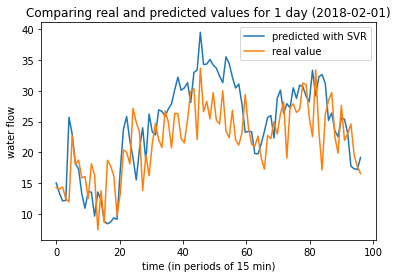

In [35]:
# just to test
predict_1d=predict_days(y_true, y_pred, 1)

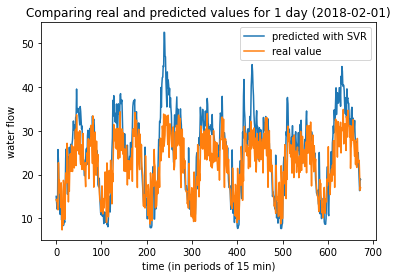

In [36]:
predict_7d=predict_days(y_true, y_pred, 7)

## Anomaly detection

1. The difference between the SVR model prediction and the actual value was divided by the average value for that time of day.

    1.1 SVR model pedriction (y_pred)
    
    1.2 actual value (y_true)
    
    1.3 y_pred - y_true / average = result


2. When the modulus of the resulting value was greater than the tolerance with 'E', this was classed as a "surprise".

    2.1 |result| > E = surprise

In [ ]:
"""
Threshold

The main idea is to minimize the error, individualizing the hyperplane that maximizes the margin
Margin/boundary/limit
"""
def margins(y_pred):
    upper=[]
    lower=[]
    epsilon=5
    upper.append(epsilon+y_pred[i])
    lower.append(y_pred[i]+epsilon)
    
    return upper, lower

In [ ]:
"""
Difference between SVR model prediction and actual values
"""
def difference(y_pred, y_true, upper, lower):
    normal=[]
    surpise=[]
    for i in range(y_true[i]):    
        if i >= upper[i] or i <= lower[i]:
            # we're just working with the flow
            surprise.append(y_true[i])
        else:
            normal.append(y_true[i])
    
    return normal, surprise

In [ ]:
"""
Calculate average value for that time of day
"""
def average(y_true):
    

    return np.average(y_true)

Note: more specifically, a surprise occurs when the difference between the observed and the predicted value is more than a given number, the tolerance wighth of standard deviations for that time of day (in paper, is 5).

3. If enough surprises occur (as calculated using the proportion of surprises in the training dataset) within a moving event window (of fixed size), this signals a novel event detection.

In [ ]:
def plotMovingAverage(series, #window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

### Ads anomalys

In [ ]:
#ads_anomaly = df.copy()
#ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

In [ ]:
#plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)